# Multi-stability {#sec-multistability}

In this section, we illustrate complex phenomena around multi-stability in the phase space of CRLD.

First, we import everything we need:

In [1]:
#| echo: false
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 180

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from pyCRLD.Environments.EcologicalPublicGood import EcologicalPublicGood as EPG
from pyCRLD.Agents.StrategyActorCritic import stratAC
from pyCRLD.Utils import FlowPlot as fp

## Phase space plot

We start by plotting the flow of CRLD in the strategy phase space projection of the prosperous state. 
For that, we define a function, to help us compile as initial strategies.

In [3]:
def compile_strategy(p0c:float,  # cooperation probability of agent zero
                     p1c:float):  # cooperation probability of agent one
    Pi = np.array([0.95, p0c])  # coop. prob. in degraded state set to 0.95
    Pj = np.array([0.95, p1c])
    xi = np.array([Pi, 1-Pi]).T
    xj = np.array([Pj, 1-Pj]).T
    return np.array([xi, xj])                         

For example, 

In [4]:
compile_strategy(0.2, 0.95)

array([[[0.95, 0.05],
        [0.2 , 0.8 ]],

       [[0.95, 0.05],
        [0.95, 0.05]]])

The arrows indicate the strategy-average reward-prediction errors. Their colors additionally indicate their length.

Trajectory length: 296
Trajectory length: 298
Trajectory length: 253


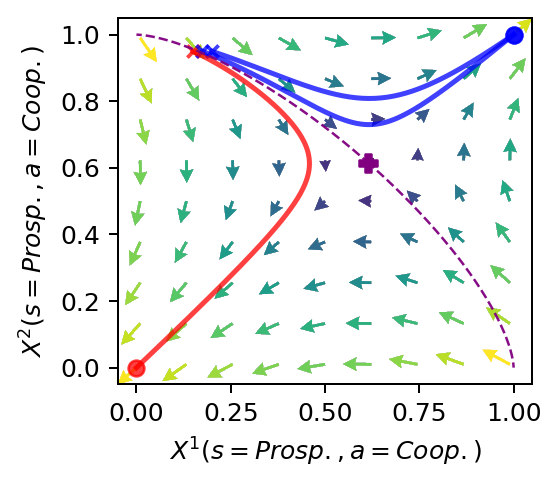

In [13]:
#| fig-cap: "Phase space projection of the prosperous state of the ecological public goods environment"
# Inititalize the ecological public good environment
env = EPG(N=2, f=1.2, c=5, m=-5, qc=0.2, qr=0.01, degraded_choice=False)

# Create multi-agent environment interface
MAEi = stratAC(env=env, learning_rates=0.1, discount_factors=0.75)

# Strategy flow plot
# ------------------
x = ([0], [1], [0])  # which (agent, observation, action) to plot on x axis
y = ([1], [1], [0])  # which (agent, observation, action) to plot on y axis
eps=10e-3; action_probability_points = np.linspace(0+eps, 1.0-eps, 9)
ax = fp.plot_strategy_flow(MAEi, x, y, action_probability_points, NrRandom=64)

# Trajectories
# ------------------
xtrajs = []  # storing strategy trajectories 
fprs = []    # and whether a fixed point is reached
for pc in [0.15, 0.175, 0.2]:  # cooperation probability of agent 2
    X = compile_strategy(pc, 0.95)
    xtraj, fixedpointreached = MAEi.trajectory(X, Tmax=2000, tolerance=10**-5)
    xtrajs.append(xtraj); fprs.append(fixedpointreached)
    print("Trajectory length:",len(xtraj))
    
# Add trajectories to flow plot
fp.plot_trajectories(xtrajs, x=x, y=y, fprs=fprs,
                     cols=['red','blue','blue'], lws=[2], msss=[2],
                     lss=['-'], alphas=[0.75],
                     axes=ax)

# Add separatrix
o = [0.619, 0.6191]; o1 = compile_strategy(*o); o2 = compile_strategy(*o[::-1])
sep1=[]; sep2=[]
for _ in range(1000): o1, _ = MAEi.reverse_step(o1); sep1.append(o1)
for _ in range(1000): o2, _ = MAEi.reverse_step(o2); sep2.append(o2)
fp.plot_trajectories([sep1, sep2], x=x, y=y, cols=['purple'], lws=[1],
                     lss=['--'], alphas=[0.95], plot_startmarker=False, axes=ax)

# Add saddle node
# by reversing the dynamics from two agents with identical strategies
o = [0.5, 0.5]; o = compile_strategy(*o)
for _ in range(1000): o, _ = MAEi.reverse_step(o)
ax[0].scatter(*o[:,1,0], c='purple', marker='P', s=50)

# Make labels nice
ax[0].set_ylabel(f"$X^2(s=Prosp.,a=Coop.)$")
ax[0].set_xlabel(f"$X^1(s=Prosp.,a=Coop.)$")

# # Save plot
plt.gcf().set_facecolor('white') # for dark mode on web
plt.tight_layout() 
plt.savefig('_figs/fig_01PhaseSpace.png', dpi=150)

## Sample trajectories
Next, we create a more fine-grained bundle of learning trajectories.

In [14]:
# Cooperation probability of agent 2
pcs = np.concatenate((np.linspace(0.05, 0.95, 51),
                       np.linspace(0.15, 0.18, 101),
                       np.linspace(0.1646, 0.1649, 101),
                       np.linspace(0.16475, 0.164765, 51)))
pcs = np.sort(np.unique(pcs))

xtrajs = []  # storing strategy trajectories 
fprs = []    # and whether a fixed point is reached
for pc in pcs:
    # Compile initial joint strategy
    Pi = np.array([0.95, pc])
    Pj = np.array([0.95, 0.95])
    xi = np.array([Pi, 1-Pi]).T
    xj = np.array([Pj, 1-Pj]).T
    X = np.array([xi, xj])

    # Compute trajectory
    xtraj, fixedpointreached = MAEi.trajectory(X, Tmax=2000, tolerance=10**-5)
    xtrajs.append(xtraj)
    fprs.append(fixedpointreached)

We obtain the critical point in this bundle of learning trajectories where the two agents switch or tip from complete defection to complete cooperation.

In [15]:
# assuming, that all trajectories convergend
assert np.all(fprs)

# obtaining the cooperation probability at convergences
converged_pcs = [xtraj[-1][:, 1, 0] for xtraj in xtrajs]

# showing the biomodal distribution of full defection and full cooperation
np.histogram(np.array(converged_pcs).mean(-1), range=(0,1))[0]

array([138,   0,   0,   0,   0,   0,   0,   0,   0, 162])

Thus, the critical point lies at the index

In [16]:
cp = np.histogram(np.array(converged_pcs).mean(-1), range=(0,1))[0][0]
cp

138

and has an approximate value between

In [17]:
print(pcs[cp-1], 'and', pcs[cp], '.')

0.1647584 and 0.1647587 .


## Critical slowing down
We use this more fine-grained bundle of learning trajectories to visualize the phenomenon of a *critical slowing down* by plotting the time steps required to reach convergence. 


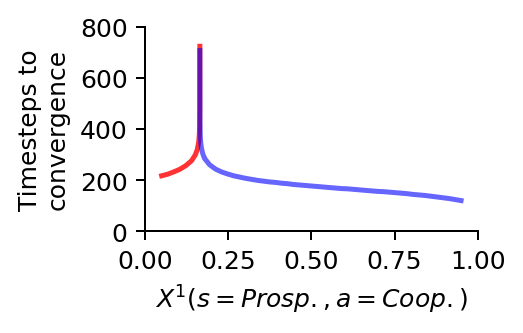

In [18]:
#| fig-cap: "Time steps required to convergence show a critical slowing down around the tipping point."

# Create the canves
fsf = 0.7 # figure size factor 
plt.figure(figsize=(fsf*4, fsf*2.5))

# Plot the time steps required to convergence, i.e. the trajectory lengths 
plt.plot(pcs[:cp], [len(xtraj) for xtraj in xtrajs[:cp]],
         '-', color='red', lw=2, alpha=0.8)  # defectors in red
plt.plot(pcs[cp:], [len(xtraj) for xtraj in xtrajs[cp:]], 
         '-', color='blue', lw=2, alpha=0.6) # cooperators in blue

# Make labels and axis nice
plt.xlabel(f"$X^1(s=Prosp.,a=Coop.)$")
plt.ylabel('Timesteps to\nconvergence')
plt.xlim(0,1)
plt.ylim(0, 800)
plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)

# Save plot
plt.gcf().set_facecolor('white') # for dark mode on web
plt.subplots_adjust(top=0.95, bottom=0.3, left=0.28, right=0.94)
plt.savefig('_figs/fig_01SlowingDown.png', dpi=150)

At the critical point $X^1_0(s=\text{Prosp.}, a=\text{Coop.}) \approx 0.16475855$, the collective learning takes about an order of magnitude longer to converge than close to full cooperation $X^1_0(s=\text{Prosp.}, a=\text{Coop.}) \approx 1.0$, and about four times as much than close to full defection $X^1_0(s=\text{Prosp.}, a=\text{Coop.}) \approx 0.0$.

## Detailed phase space

We plot a detailed phase space where we zoom in on the area around the critical saddle point on the separatrix.

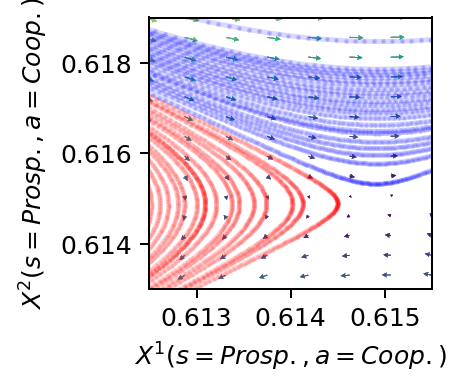

In [19]:
#| fig-cap: "Strategy phase space at the critical bifurcation point."

# Create the canves
fsf =  0.65  # figure size factor
_, ax = plt.subplots(1,1, figsize=(fsf*4, fsf*3.5))

# Plot the reward-prediction error flow
action_probability_points = np.linspace(0.612, 0.619, 17)
ax = fp.plot_strategy_flow(MAEi, x, y, action_probability_points, NrRandom=64,
                           axes=[ax])

# Plot the defecting learning trajectories in red 
fp.plot_trajectories(xtrajs[:cp], x=x, y=y, fprs=fprs, axes=ax, cols=['red'],
                     lws=[2], msss=[2], mss=['.'], lss=['-'], alphas=[0.15])

# Plot the cooperating learning trajectories in blue
fp.plot_trajectories(xtrajs[cp:], x=x, y=y, fprs=fprs, axes=ax, cols=['blue'],
                     lws=[2], msss=[2], mss=['.'], lss=['-'], alphas=[0.15])

# Make labels and axis nice
ax[0].set_ylabel(f"$X^2(s=Prosp.,a=Coop.)$")
ax[0].set_xlabel(f"$X^1(s=Prosp.,a=Coop.)$")

ax[0].set_ylim(0.613, 0.619)
ax[0].set_xlim(0.6125, 0.6155)

# Save plot
plt.gcf().set_facecolor('white') # for dark mode on web
plt.tight_layout()
plt.savefig('_figs/fig_01PhaseSpaceDetail.png', dpi=150)

## Time scale separation
Last, we visulize the emergent time scale separation at the critical point by plotting the level of cooperation over time for the two initial strategies around the critical point.

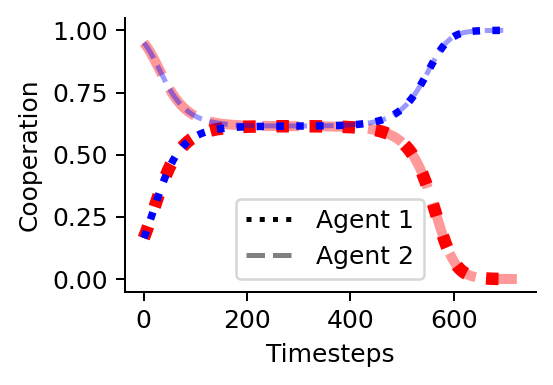

In [21]:
#| fig-cap: "Emergent time scale seperation at the critical point."

# Create the canves
fsf = 0.5  # figure size factor
plt.figure(figsize=(fsf*6, fsf*4))

# Plot the defecting learners in red
#   agent 1 with dots
plt.plot(xtrajs[cp-1][:, 0, 1, 0], color='red', lw=5, ls=':') 
#   agent 2 with dashes
plt.plot(xtrajs[cp-1][:, 1, 1, 0], color='red', lw=4, ls="--", alpha=0.4)

# Plot the cooperating learners in blue
#   agent 1 with dots
plt.plot(xtrajs[cp][:, 0, 1, 0], color='blue', lw=3, ls=':')
#   agent 2 with dashes
plt.plot(xtrajs[cp][:, 1, 1, 0], color='blue', lw=2, ls="--", alpha=0.4)

# Create a nice legend
custom_lines = [Line2D([0], [0], color='black', ls=':', lw=2),
                Line2D([0], [0], color='gray', ls='--', lw=2)]
plt.legend(custom_lines, ['Agent 1', 'Agent 2'], ncol=1)

# Make labels and axis nice
plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)
plt.xlabel("Timesteps")
plt.ylabel("Cooperation")

# Save plot
plt.gcf().set_facecolor('white') # for dark mode on web
plt.subplots_adjust(top=0.98, bottom=0.22, left=0.22, right=0.98)
plt.savefig('_figs/fig_01PhaseSpaceTrajectory.png', dpi=150)